# Explore here

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

url = "/workspaces/linear-regression-PereHDZ/insurance_data.csv"

df = pd.read_csv(url, sep=',')

df.to_csv('insurance_data.csv', index=False)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [127]:
#Check the number of rows and columns
df.shape

(1338, 7)

In [128]:
#Check the type of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [129]:
#Check for constant values
df.nunique()

#There are no constant values

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [130]:
#check for duplicates
df.duplicated().sum()

np.int64(1)

In [131]:
#Since we have duplicate entries in the dataset, we should eliminate them to avoid redundancy in our algorithm
df = df.drop_duplicates()
df = df.reset_index(drop=True)

df.duplicated().sum()

np.int64(0)

In [132]:
#Basic column description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [133]:
#Check for empty elements in the dataset
df.isnull().mean()*100

#There are no missing elements

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [134]:
#Transforming categorical variables to numerical

#Binary variables
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

#Other variables
# value_counts = df['region'].value_counts()
# print(value_counts)
df['region'] = df['region'].map({'southeast': 0, 'southwest': 1, 'northwest': 2, 'northeast': 3})

df.info()

#All of our variables are numerical now


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   int64  
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   int64  
 5   region    1337 non-null   int64  
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 73.2 KB


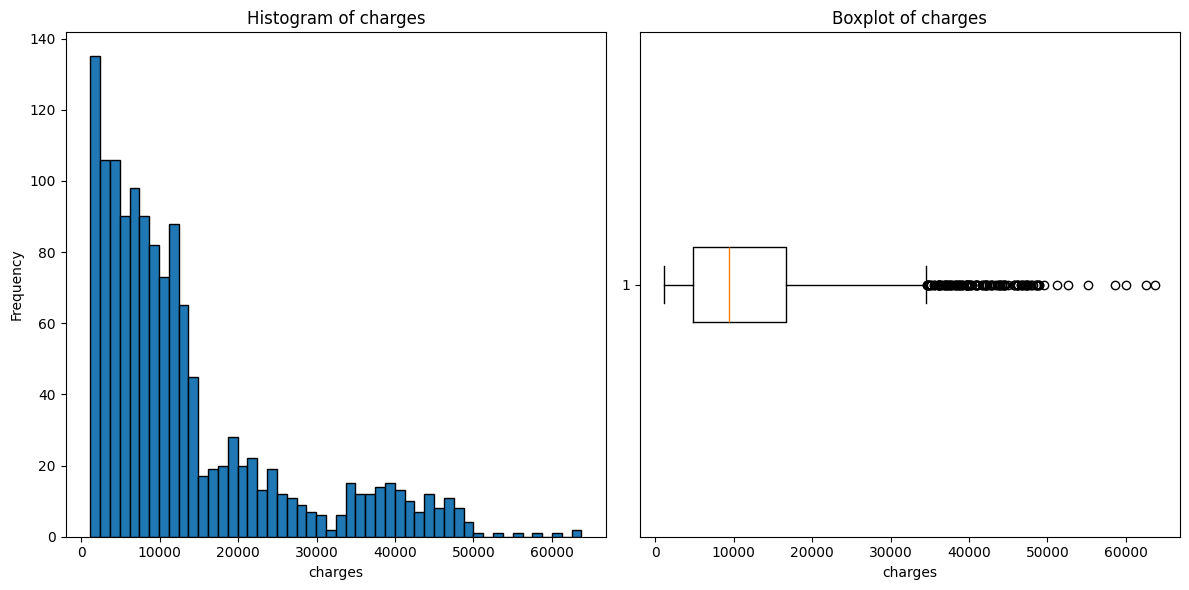

In [135]:
#Plot histogram and boxplot of the variable 'price'

plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df['charges'], bins=50, edgecolor='black')
plt.xlabel('charges')
plt.ylabel('Frequency')
plt.title('Histogram of charges')

# Boxplot
plt.subplot(1, 2, 2) 
plt.boxplot(df['charges'], vert=False)
plt.xlabel('charges')
plt.title('Boxplot of charges')

plt.tight_layout()
plt.show()

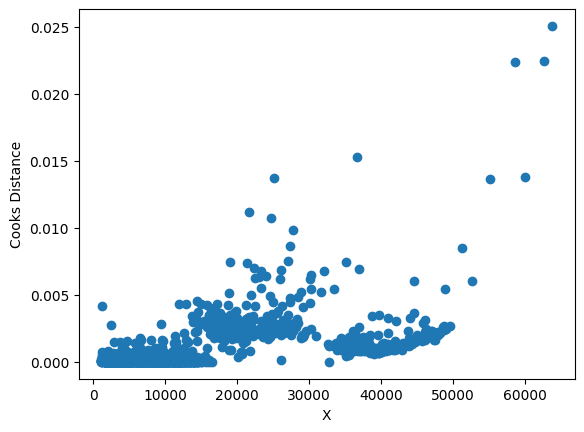

In [136]:
#Calculate Cook's distance
X = df.drop(['charges'], axis=1)
y = df['charges']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

cooks_distance = model.get_influence().cooks_distance

plt.scatter(df.charges, cooks_distance[0])
plt.xlabel('X')
plt.ylabel('Cooks Distance')
plt.show()

In [137]:
#Detect the influential observations
to_delete = np.where(cooks_distance[0]>4/len(df))
print(to_delete)

(array([   3,    9,   34,   58,   62,   69,   98,   99,  102,  115,  138,
        140,  153,  156,  219,  224,  235,  242,  250,  262,  266,  289,
        292,  301,  321,  340,  355,  376,  379,  380,  387,  397,  411,
        412,  430,  443,  468,  488,  491,  494,  502,  516,  520,  526,
        539,  543,  573,  577,  582,  586,  592,  598,  636,  657,  660,
        687,  695,  726,  729,  738,  753,  779,  792,  798,  802,  805,
        818,  853,  859,  895,  935,  974,  979,  988,  993, 1007, 1010,
       1011, 1018, 1026, 1032, 1038, 1046, 1079, 1084, 1099, 1123, 1141,
       1145, 1155, 1194, 1205, 1229, 1257, 1281, 1299, 1305, 1306, 1313,
       1316, 1327]),)


In [138]:
#Delete influential observations
df1 = df.drop(np.where(cooks_distance[0]>4/len(df))[0])

#Data split
X = df1.drop(['charges'], axis=1)
y = df1['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
#Visualize the importance of each observation on charges
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_ * 100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

,Feature,Importance
4,smoker,96.436600
2,bmi,1.449200
0,age,1.358647
3,children,0.281741
5,region,0.274620
1,sex,0.199196


In [140]:
#Since the amount of variables isn't very big, we will remove those that had an importance of less than 1%
X_train = X_train[df_imp[df_imp.Importance > 1]['Feature'].values]
X_test = X_test[df_imp[df_imp.Importance > 1]['Feature'].values]

#Show correlation between variables
X_corr = X_train.copy()
X_corr['charges'] = y_train
corr = X_corr.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,smoker,bmi,age,charges
smoker,1.000,0.035,0.025,0.847
bmi,0.035,1.000,0.115,0.196
age,0.025,0.115,1.000,0.348
charges,0.847,0.196,0.348,1.000


In [141]:
'''After calculating the importance and correlation of the variables, we can see that being a smoker is most likely the biggest factor in 
rising insurance prices'''

#VIF calculation
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

calculate_vif(X_train.corr())

,Feature,VIF
0,smoker,1.006825
1,bmi,1.058954
2,age,1.056279


In [142]:
#Create the linear regression model
X = sm.add_constant(X)
model = sm.OLS(y, X)

#Adjust our dataset to the model
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1156.
Date:                Wed, 29 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:10:12   Log-Likelihood:                -12135.
No. Observations:                1236   AIC:                         2.428e+04
Df Residuals:                    1229   BIC:                         2.432e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.123e+04    813.984    -13.800      0.0

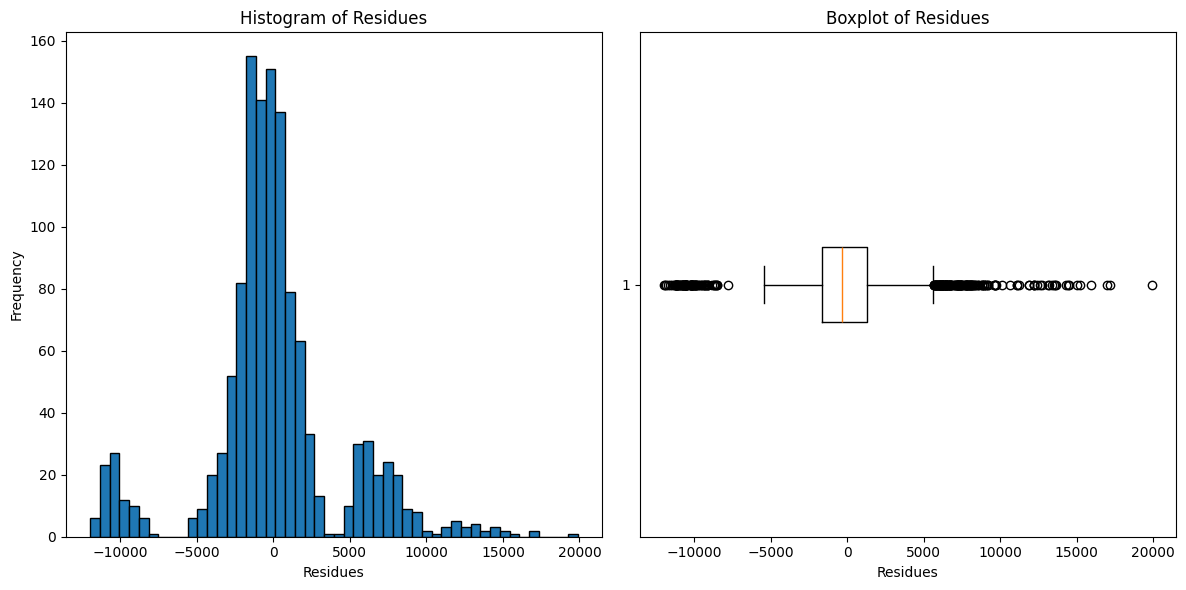

In [143]:
'''We got an R-squared of 0'85, which is rather high. Since we have a prob of 0, we must reject H0, meaning that at least one of our 
coefficients is statistically different to 0.'''
#Plot the residues
residues = results.resid

plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(residues, bins=50, edgecolor='black')
plt.xlabel('Residues')
plt.ylabel('Frequency')
plt.title('Histogram of Residues')

# Boxplot
plt.subplot(1, 2, 2) 
plt.boxplot(residues, vert=False)
plt.xlabel('Residues')
plt.title('Boxplot of Residues')

plt.tight_layout()
plt.show()

In [144]:
#Check the mean of our residues to see if we have a high variance (meaning that a lot of our errors were rather high)
np.mean(residues)

#A mean so close to 0 means that our errors were close to the accurate mark

np.float64(-7.005169547636146e-13)

In [145]:
#Check the normality of our errors
stats.shapiro(residues)

'''With a Shapiro so close to 0, we can assume normality in our errors. This is important, as a skewed distribution could mean that our
datamodel is biased'''

ShapiroResult(statistic=np.float64(0.9039001112165169), pvalue=np.float64(3.544788490644864e-27))